In [1]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary

from matplotlib import pyplot as plt

import mitdeeplearning as mdl

import numpy as np
from tqdm import tqdm

# Downloading the dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(),])
train_dataset = datasets.MNIST(root ='./data', train= True, transform = transform, download= True)
test_dataset = datasets.MNIST(root = './data', train = False, transform= transform, download = True)

# Printng Sample dataset

In [4]:
image, label = train_dataset[0]
print(f"Printing image shape: {image.shape} and label:{label}")


Printing image shape: torch.Size([1, 28, 28]) and label:5


The above image printing shows that the image are 28x28 pixel rows and colums or height x width. lets display them

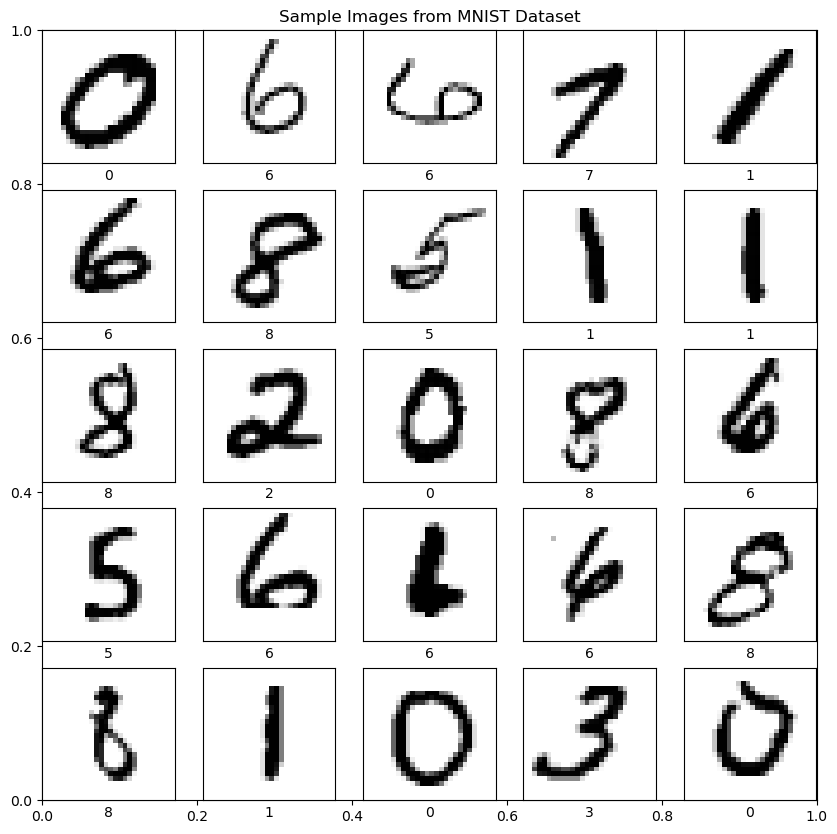

In [6]:
plt.figure(figsize=(10,10))
plt.title("Sample Images from MNIST Dataset")

random_indices = np.random.choice(6000,25)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    image_indx = random_indices[i]
    image,label = train_dataset[image_indx]
    plt.imshow(image.squeeze(),cmap = plt.cm.binary)
    plt.xlabel(label)

plt.show()


# Using CNN for MNIST Images Classification

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(). __init__()
        self.conv1 = torch.nn.Conv2d(1,32,kernel_size=3)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32,64,kernel_size=3)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*5*5, 128)

        self.relu = nn.ReLU()


        self.fc2 = nn.Linear(128,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        

        return x
        


# cnn_model With Sample Data

In [8]:
cnn_model = CNN().to('cuda')
image , label = train_dataset[0]
image = image.to('cuda').unsqueeze(0)
output = cnn_model(image)
print(cnn_model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# Lets Train the CNN Model

In [9]:
# define parameters

epochs = 5
batch_size =64
learning_rate = 1e-2

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr= learning_rate)

trainset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testset_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

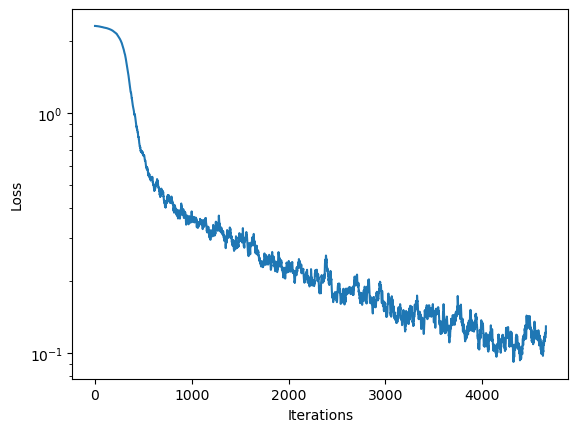

Epoch 6/5 - Loss: 0.0000, Accuracy: 0.9650


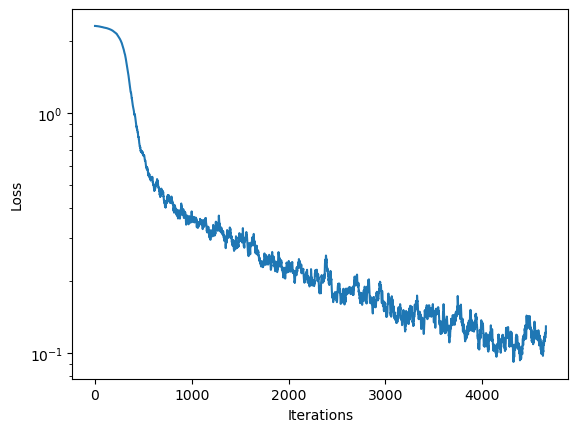

In [10]:
#Evaluate the Model
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the elevation of loss during training
plotter = mdl.util.PeriodicPlotter(sec=2 , xlabel = 'Iterations', ylabel= 'Loss', scale = 'semilogy')

if hasattr(tqdm, '_instances'):
    tqdm._instances.clear() # clear the prevous tqdm instance if any

cnn_model.train()
for epoch in range(epochs):
    total_loss = 0
    correct_pred = 0
    total_pred = 0
    for idx, (images, labels) in enumerate(trainset_loader):
        images = images.to('cuda')
        labels = labels.to('cuda')

        #forward pass
        outputs = cnn_model(images)

        #computer the loss
        loss = loss_function(outputs, labels)

        # get the loss value and log it
        loss_value = loss.item()
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #get the prediction and calculate accuracy
        predicted = torch.argmax(outputs, dim=1)
        correct_pred += (predicted == labels).sum().item()
        total_pred += labels.size(0)

    #compute the accuracy for the epoch
    total_epoch_loss = total_loss / total_pred
    epoch_accuracy = correct_pred / total_pred

print(f"Epoch {epochs+1}/{epochs} - Loss: {total_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")



# Make Predicions with CNN

In [11]:
test_image, test_label = test_dataset[0]
test_image = test_image.to('cuda').unsqueeze(0)
cnn_model.eval()  # Set the model to evaluation mode
prediction_test_image = cnn_model(test_image)

In [56]:
# Lets print the prediction_test_image
prediction_test_image

tensor([[ -1.8069,  -3.3966,   5.0683,   4.1793,  -6.6697,  -1.2996, -12.2828,
          13.8253,  -2.2920,   2.7005]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [16]:
predictions_value = prediction_test_image.cpu().detach().numpy()
print(predictions_value)
predictions = np.argmax(predictions_value)
print(predictions)

[[  0.2891738   -5.2691197    4.5304723    3.622718    -6.398382
   -1.7216711  -11.357234    13.004599    -0.68946755   2.89733   ]]
7


Predicted label: 7, Actual label: 7


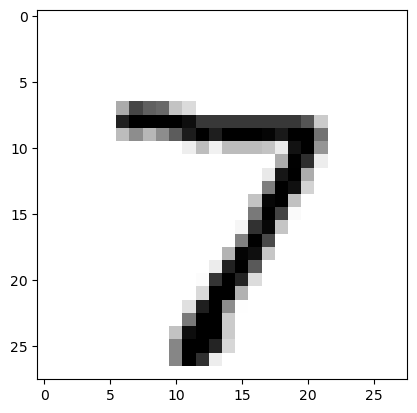

In [18]:
# To check whether the model prediction is correct or other wise
print(f"Predicted label: {predictions}, Actual label: {test_label}")
plt.imshow(test_image[0,0,:,:].cpu(), cmap=plt.cm.binary)

In [21]:
#initialize variables to store teh data

all_predictions = []
all_labels = []
all_images = []

# process test set in batches
with torch.no_grad():
    for images, labels in testset_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        #forward pass
        outputs = cnn_model(images)

        #Apply softmax to get probabilities from the predicted logits
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        #get the predicted labels
        predicted_labels = torch.argmax(probabilities, dim=1)
        
        all_predictions.append(predicted_labels)
        all_labels.append(labels)
        all_images.append(images)

all_predictions = torch.cat(all_predictions)
all_labels = torch.cat(all_labels)
all_images = torch.cat(all_images)

#convert the tensors to numpy array for plotting functinos
predictions = all_predictions.cpu().numpy()
test_labels = all_labels.cpu().numpy()
test_images = all_images.cpu().numpy()




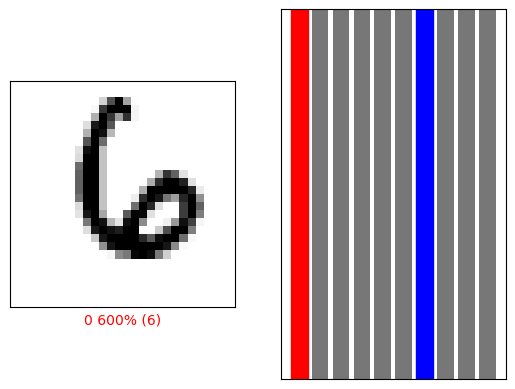

In [30]:
image_index = 88
plt.subplot(1,2,1)
mdl.lab2.plot_image_prediction(image_index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
mdl.lab2.plot_value_prediction(image_index, predictions, test_labels)

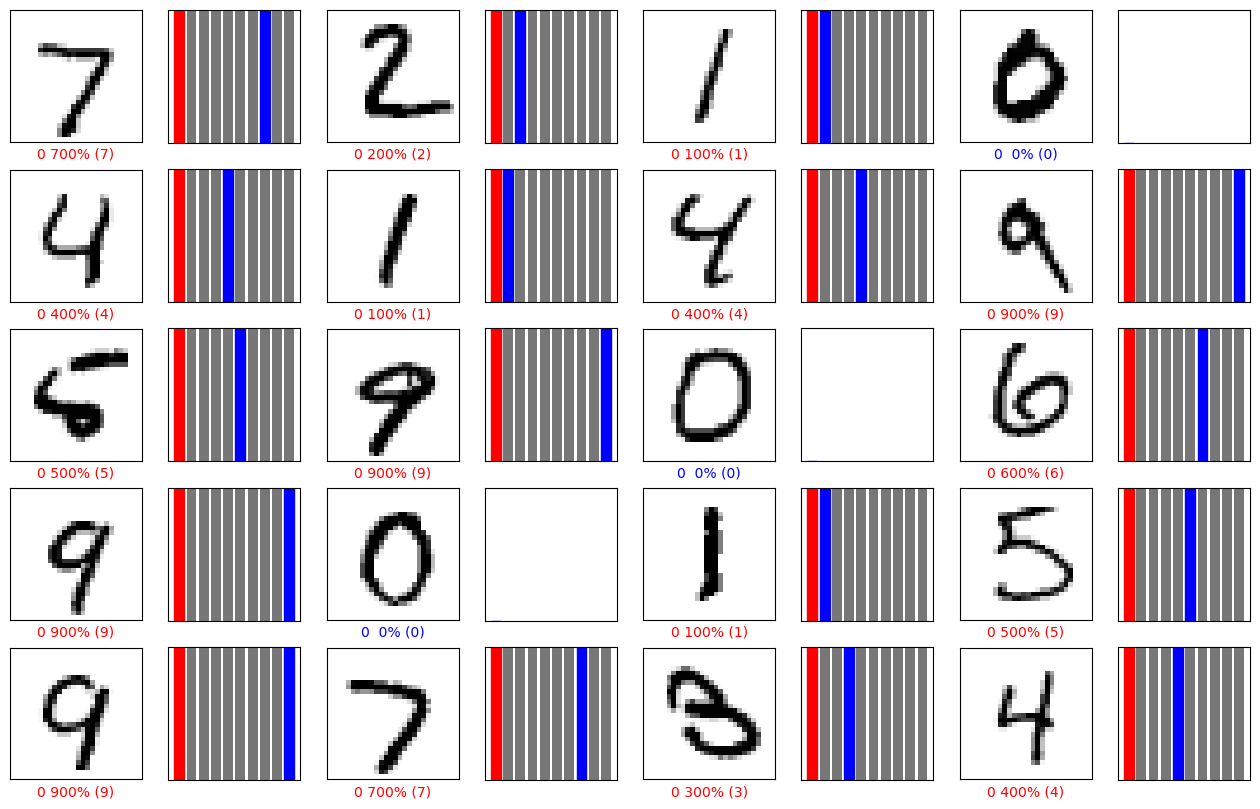

In [31]:
# Plots the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  mdl.lab2.plot_image_prediction(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  mdl.lab2.plot_value_prediction(i, predictions, test_labels)
